![University of Tehran](./img/UT.png)
#   <font color='red'><center>AI CA 5 - Phase 1<center></font> 
## <center>Dr. Fadaei<center>
### <center>Daniyal Maroufi<center>
### <center>810098039<center>


## Aim

This assignment aims to implement a neural networks API from scratch and use it to train a model for classifying handwritten Persian numbers.


# Dataset

The dataset consists of 102353 handwritten Persian numbers of digits 0 to 9.

![Digits_Sample](./img/Digits_Sample.gif)

# Part 1 - Preprocessing

In [51]:
import copy
import random
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [35]:
with open('dataset/data.pkl','rb') as f:
    data=pickle.load(f)
with open('dataset/labels.pkl','rb') as f:
    labels=pickle.load(f)


In [36]:
# https://github.com/amir-saniyan/HodaDatasetReader/blob/master/HodaDatasetReader.py
def resize_image(src_image, dst_image_height=25, dst_image_width=25):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image

In [37]:
n_data=len(data)

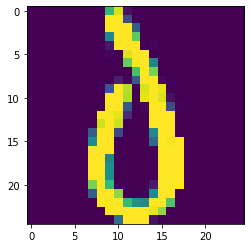

In [38]:
img_idx=random.randint(0,n_data)
img=resize_image(data[img_idx])
plt.imshow(img)
plt.show()

In [39]:
for i in range(n_data):
    data[i]=resize_image(data[i])


In [40]:
print('The value of each pixel is between',np.min(data[i]),'and',np.max(data[i]))

The value of each pixel is between 0 and 255


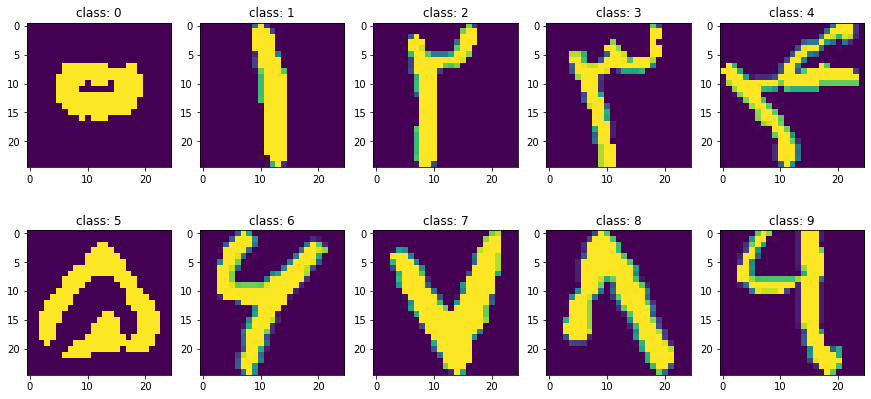

In [41]:
plt.figure(figsize=(15,7))
for class_idx in range(10):
    for i in range(n_data):
        if labels[i]==class_idx:
            plt.subplot(2,5,class_idx+1)
            plt.imshow(data[i])
            plt.title('class: '+str(class_idx))
            break

plt.show()

In [42]:
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.2)

In [22]:
train_classes_samples_count=defaultdict(lambda: 0)
test_classes_samples_count=defaultdict(lambda: 0)

for class_idx in y_train:
    train_classes_samples_count[class_idx]+=1

for class_idx in y_test:
    test_classes_samples_count[class_idx]+=1


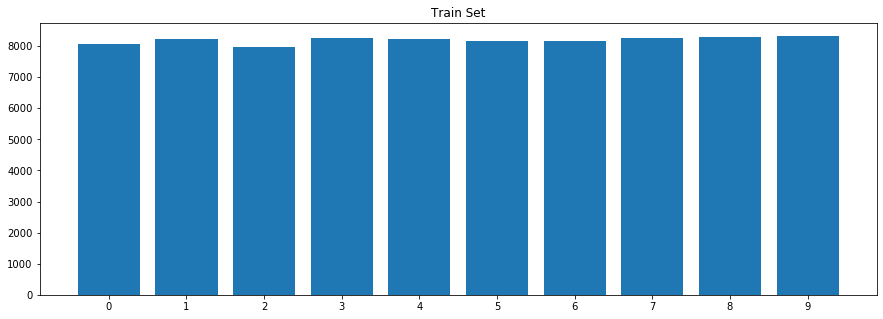

In [28]:
plt.figure(figsize=(15,5))
plt.bar(train_classes_samples_count.keys(),train_classes_samples_count.values())
plt.xticks([i for i in range(10)])
plt.title('Train Set')
plt.show()

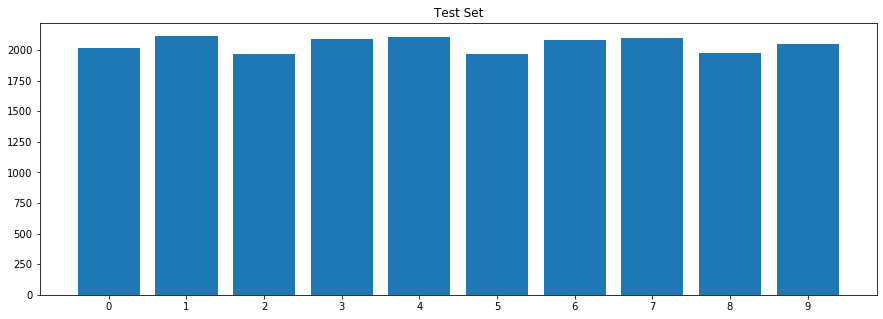

In [30]:
plt.figure(figsize=(15,5))
plt.bar(test_classes_samples_count.keys(),test_classes_samples_count.values())
plt.xticks([i for i in range(10)])
plt.title('Test Set')
plt.show()

## Scaling
The rescaling of inputs tries to keep the range of weights in a small range. Theoretically, it is not necessary to rescale the inputs because an appropriate redefinition of the weights can compensate for it. Practically it is important because the weights might occupy a very large range of values.

$x_{scaled}=\dfrac{x}{255}$

In [43]:
for i in range(len(x_train)):
    x_train[i]=x_train[i]/255

for i in range(len(x_test)):
    x_test[i]=x_test[i]/255


# Part 2 - Implementation

## Dataloader

In [44]:
class Dataloader:
    '''
    This class prepares the dataset for the neural network.
    '''
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        '''
        This is the constructor. It gets dataset information and initializes the 
        Dataloader class fields.
            Parameters:
                data: features your dataset in pandas.Dataframe format.
                labels: labels of your dataset in pandas.Dataframe format.
                n_classes: number of classes you have in your dataset.
                batch_size: the number of samples that will be propagated through the network.
                shuffle: boolean value indicating whether or not the dataset should be shuffled
        '''

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        '''
        This private method gets labels and provides one_hot vectors of labels.
        For categorical variables where no such ordinal relationship exists,
        the integer encoding is not enough.
        In this case, a one-hot encoding can be applied to the integer representation.
        This is where the integer encoded variable is removed, and a new binary variable is
        added for each unique integer value.
        example:
            red,    green,    blue
            1,      0,        0
            0,      1,        0
            0,      0,        1
                Parameters:
                        label: lables of your dataset in pandas.Dataframe format.
                        n_classes: number of classes you have in your dataset.
                
                Returns:
                    onehot_vectors: onehot vectors of the labels
        '''
        onehot_vectors_list = []
        for i in range(len(labels)):
            onehot_vectors_i = np.zeros(n_classes)
            classNum = labels[i]
            onehot_vectors_i[classNum] = 1
            onehot_vectors_list.append(onehot_vectors_i)
        onehot_vectors = np.array(onehot_vectors_list)
        return onehot_vectors
    
    def __shuffle_dataset(self):
        '''
        This private method shuffles your dataset.
        It uses data and onehot_labels to shuffle them
        symmetrical.
        '''
        self.__data, self.__onehot_labels = shuffle(self.__data, self.__onehot_labels, random_state=0)
    
    def __iter__(self):
        '''
        The __iter__() function returns an iterator for the
        given object (array, set, tuple, etc., or custom objects).
        This will return your dataset in the batch_size given. This should
        be used to provide data for the neural network.
        '''

        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))


## Activation Functions

In [48]:
class Identical:
    '''
    This is the Identical activation function. This activation function just
    return the value it gets.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        As this is an identical activity function, it just 
        returns np.matrix of the input.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_value: np.matrix of input with float datatypes
        '''
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        '''
        This method returns the derivation of the input.
        As the derivation of x is one, this method returns
        a matrix of one with the shape of the input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_derivative: np.matrix of ones with matrix shape
        '''
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _value method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    

class Relu:
    '''
    This is the Relu activation function. 
    The rectified linear activation function or ReLU for short
    is a piecewise linear function that will output the input directly
    if it is positive, otherwise, it will output zero.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set 0 in the matrix if the value is less than 0 else, it returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        relu_value = np.array(matrix, dtype=float)
        relu_value = np.maximum(relu_value, 0)
        return relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_derivative: np.matrix of relu activation function derivation result
        '''
        relu_derivative = np.array(matrix, dtype=float)
        relu_derivative = np.where(relu_derivative > 0, 1, 0)
        return relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _relu method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __relu(matrix): __relu return value for the input matrix
        '''
        return self.__val(matrix)

    
class LeakyRelu:
    '''
    This is the Leaky Relu activation function. 
    Leaky Rectified Linear Unit, or Leaky ReLU,
    is a type of activation function based on a ReLU,
    but it has a small slope for negative values instead
    of a flat slope.
    '''
    
    def __init__(self, negative_slope=0.01):
        '''
        This is the constructor.
        It sets negative_slope field.
            Parameters:
                negative_slope: slope for negative input values
        '''
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set negative_slope*value in the matrix if the value is less than 0, else it
        returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        leacky_relu_value = np.array(matrix, dtype=float)
        leacky_relu_value = np.where(leacky_relu_value > 0, leacky_relu_value, leacky_relu_value* 0.01)     
        return leacky_relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of leaky relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                leacky_relu_derivative: np.matrix of leaky relu activation function derivation result
        '''
        leacky_relu_derivative = np.array(matrix, dtype=float)
        leacky_relu_derivative = np.where(leacky_relu_derivative > 0, 1, self.negative_slope)
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

    
class Sigmoid:
    '''
    A sigmoid function is a mathematical function having a
    characteristic "S"-shaped curve or sigmoid curve.
    It return S(x)=1/(1+e^-x)
    '''
    
    def __init__(self): pass

    def __val(self, matrix):
        '''
        Returns 1/(1+e^-x) of values
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_value: np.matrix of relu activation function result
        '''
        sigmoid_value = np.array(matrix, dtype=float)
        sigmoid_value = 1/(1+np.exp(-sigmoid_value))
        return sigmoid_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of sigmoid function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of sigmoid activation function derivation result
        '''
        sigmoid_derivative = np.array(matrix, dtype=float)
        sigmoid_derivative = (1/(1+np.exp(-sigmoid_derivative)))*(1-(1/(1+np.exp(-sigmoid_derivative))))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)


class Softmax:
    '''
    The softmax function, also known as softargmax  or normalized
    exponential function is a generalization of the logistic
    function to multiple dimensions. It is used in multinomial logistic
    regression and is often used as the last activation function of a neural
    network to normalize the output of a network to a probability distribution
    over predicted output classes, based on Luce's choice axiom.
    Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
    '''
        
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the softmax on that.
        Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        softmax_value = np.array(matrix, dtype=float)
        for i in range(softmax_value.shape[0]):
          max = np.max(softmax_value[i])
          num = np.exp(np.subtract(softmax_value[i], max))
          den = np.sum(num)
          softmax_value[i] = np.divide(num, den)
        return np.clip(softmax_value,1e-37,1)
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    
class Tanh:
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It performs Tanh on the values.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                tanh_value: np.matrix of Tanh activation function result
        '''
        tanh_value = np.array(matrix, dtype=float)
        tanh_value = np.tanh(tanh_value)
        return tanh_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of Tanh function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of Tanh activation function derivation result
        '''
        tanh_derivative = np.array(matrix, dtype=float)
        tanh_derivative = (1-(np.tanh(tanh_derivative))*(np.tanh(tanh_derivative)))
        return tanh_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

# Loss Function

In [49]:
class CrossEntropy:
    '''
    Cross-entropy is a measure of the difference between two probability
    distributions for a given random variable or set of events. You might
    recall that information quantifies the number of bits required to encode
    and transmit an event.
    The above image can help you.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, true_val, expected_val):
        '''
        L(y^, y) = - Σ (y^(k)log (y^)^(k)) for k in K
        Parameters:
            true_val: calculated values (generated by neural network)
            expected_val: real values in dataset
        Returns:
            cross_entropy_value: cross entropy of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        cross_entropy_value = -1*np.sum(np.multiply(expected_val, np.log10(true_val)))
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        '''
        Returns derivation of cross entropy.
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                cross_entropy_derivative: cross entropy derivation of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        cross_entropy_derivative = true_val - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(true_val, expected_val)

# Layer

In [50]:
class Layer:
    '''
    The layer class is used to define neural network layers.
    It stores all needed information for each layer, such as neurons count,
    weight matrix, bias, the output after applying the activation function, etc.
    '''

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
        '''
        Parameters:
            input_size: the size of the input of this layer.
            output_size: the size of the output after this layer.
            activation: the activation function. It can be initialized to either of the previously defined activation classes.
                               default is an Identical activation function.
            initial_weight: either normal or uniform. It defines the method for weight initialization.
        '''
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        '''
        It calculates the output of this layer for the layer_input argument.
        This method also stores __last_input, __last_activation_input, and __last_activation_derivative
        for future use in backpropagation.
        Parameters:
            layer_input: 2d np.matrix representing the input matrix of this layer.
        Returns:
            Final output of this layer after applying the activation function.
        '''
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)

        self.__last_input = layer_input
        self.__last_activation_input = np.dot(layer_input, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_output)

        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        '''
        It updates Layer weights according to the backpropagation matrix and learning rate.
        This method updates bias values as well.
        Parameters:
            backprop_tensor: 2d np.matrix passed from the next layer containing gradient values.
            lr: learning rate
        Returns:
            backprop_tensor to be used by the previous layer.
        '''
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons

        self.__weight -= lr * np.dot(np.transpose(self.__last_input), 
                                np.array(backprop_tensor)*
                                np.array(self.__last_activation_derivative))
        self.__bias -= lr * np.array(backprop_tensor) * np.array(self.__last_activation_derivative)
        backprop_tensor = np.dot(np.array(backprop_tensor)*np.array(self.__last_activation_derivative), np.transpose(self.__weight))

        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a uniform distribution between low and high values.
        It uses default low and high values unless low or high are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom low or high values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using uniformly distributed values.
        '''
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']

        weights = np.random.uniform(low=low, high=high, size=(dim1, dim2))

        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a normal distribution with mean and var values.
        It uses default mean and variance values unless mean or var are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom mean or var values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using normaly distributed values.
        ''' 
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']

        weights = np.random.normal(loc=mean, scale=var, size=(dim1, dim2))

        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [52]:
class FeedForwardNN:
    '''
    This class is used in order to implement custom feed-forward neural networks.
    The FeedForwardNN class stores a list of layers that determines all network layers.
    It also consists of the learning rate and loss function.
    '''
    def __init__(self, input_shape):
        '''
        Parameters:
            input_shape: the size of the first input to our neural network.
        '''
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        '''
         This method adds a new custom layer to the layers_list.
         Parameters:
             n_neurons: number of neurons in this layer
             activation: the activation function of this layer, default is Relu
             initial_weight: either a uniform or normal, default is uniform
             initializing_parameters: other initializing parameters such as low, high, mean, var, etc
        '''
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        '''
        This method is used to set training parameters.
        Parameters:
            loss: loss function, default is CrossEntropy
            lr: learning rate, default is 1e-3
        '''
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        '''
        This method calculates the output of the complete neural network for a passed input.
        Parameters:
            network_input: input of the neural network
        Returns:
            network_output: output of the neural network after forwarding the network_input
        '''
        assert type(self.__output_shape) != None, "Model is not compiled!"

        outputOfLayer = network_input

        for layer in self.__layers_list:
            outputOfLayer = layer.forward(outputOfLayer)

        softmax = Softmax()

        network_output = softmax(outputOfLayer)

        return network_output


    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        '''
        This method trains the neural network using specified parameters.
        It runs the __train private method epoch times and fills the log dictionary.
        Parameters:
            epochs: number of epochs to run
            trainloader: DataLoader for train data
            testloader: DataLoader for test data
            print_results: whether or not to print the results
        Returns:
            log: complete log of the training process as a dictionary consisting of
            train_accuracy, train_loss, test_accuracy, test_loss
        '''
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}

        for epoch in range(1, epochs+1):

            if print_results: 
                print('Epoch {}:'.format(epoch)) 

            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))

            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))

        return log


    def __train(self, trainloader):
        '''
        Trains the neural network for one epoch.
        Parameters:
            trainloader: A DataLoader consisting of train data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)


    def __test(self, testloader):
        '''
        Test the neural network using a testloader.
        Parameters:
            testloader: A DataLoader of test data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)


    def __train_on_batch(self, x_batch, y_batch):
        '''
        Trains the neural network for one batch of train data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''

        layers = copy.deepcopy(self.__layers_list)
        batch_size = len(x_batch)
        weight = []

        for x,y in zip(x_batch, y_batch):
            predicted_out = self.forward(x)
            if(len(weight) != 0):
                for i in range(len(self.__layers_list)):
                    self.__layers_list[i].weight = weight[i]
                    self.__layers_list[i].bias = bias[i]
            self.__update_weights(predicted_out, y)

            weight = []
            bias = []
            for layer in self.__layers_list:
                weight.append(layer.weight)
                bias.append(layer.bias)

            batch_size -= 1
            if(batch_size != 0):
                self.__layers_list = copy.deepcopy(layers)

        predicted_out_list = []
        for i in range(len(y_batch)):
            predicted_out_list.append(self.forward(x_batch[i]))

        batch_accuracy = self.__compute_accuracy(predicted_out_list, y_batch)
        batch_average_loss = 0

        for i in range(len(y_batch)):
            batch_average_loss = self.__loss(predicted_out_list[i], y_batch[i])
        batch_average_loss = batch_average_loss/(len(y_batch))

        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        '''
        Tests the neural network for one batch of test data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''

        predicted_out_list = []
        for i in range(len(y_batch)):
            predicted_out_list.append(self.forward(x_batch[i]))
        batch_accuracy = self.__compute_accuracy(predicted_out_list, y_batch)

        batch_average_loss_list = []
        for i in range(len(y_batch)):
            batch_average_loss_list.append(self.__loss(predicted_out_list[i], y_batch[i]))
        batch_average_loss=np.sum(batch_average_loss_list)/len(y_batch)

        return (batch_accuracy, batch_average_loss)


    def __get_labels(self, outputs):
        '''
        Parameters:
            outputs: output of the neural network
        Returns:
            labels: labels generated from the outputs of the neural network
        '''

        labels = np.zeros(len(outputs))
        for i in range(len(outputs)):
            labels[i] = np.argmax(outputs[i])

        return labels


    def __compute_accuracy(self, output, expected_output):
        '''
        Computes accuracy by comparing output and expected_output.
        Parameters:
            output: actual output of the neural network
            expected_output: expected output
        Returns:
            accuracy
        '''
        accuracy = 0
        for i in range(len(output)):
            if(np.argmax(output[i]) == np.argmax(expected_output[i])):
                accuracy += 1
        accuracy = accuracy/len(output)
        return accuracy


    def __update_weights(self, output, y_train):
        '''
        Updates weights of all layers according to neural network output and labels.
        Parameters:
            output: output of the neural network
            y_train: y labels for one batch of train data
        Returns:
            None
        '''

        backprop_tensor = self.__loss.derivative(output, y_train)
        for layer_i_idx in range(len(self.__layers_list)-1, -1, -1):
            backprop_tensor = self.__layers_list[layer_i_idx].update_weights(backprop_tensor, self.__lr)   

        return

# Training Sample Code

In [56]:
# Sample code for building and training a model

INPUT_SHAPE = 25*25
LEARNING_RATE = 0.001
EPOCHS = 15
TRAINLOADER = Dataloader(x_train,y_train,n_classes=10,batch_size=32)
TESTLOADER = Dataloader(x_test,y_test,n_classes=10,batch_size=32)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=16, input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(n_neurons=20, activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)


Epoch 1:


ValueError: matrix must be 2-dimensional